In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 941, done.
remote: Counting objects: 100% (371/371), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 941 (delta 281), reused 222 (delta 163), pack-reused 570
Receiving objects: 100% (941/941), 14.32 MiB | 16.95 MiB/s, done.
Resolving deltas: 100% (621/621), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 25.4 MB/s eta 0:00:00


In [3]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In functio

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/hyperparameters-tuning-better/best_params_ials_v2.json
/kaggle/input/hyperparameters-tuning-better/__results__.html
/kaggle/input/hyperparameters-tuning-better/better_tuning.db
/kaggle/input/hyperparameters-tuning-better/__notebook__.ipynb
/kaggle/input/hyperparameters-tuning-better/__output__.json
/kaggle/input/hyperparameters-tuning-better/custom.css
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/run_all_algorithms.py
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/cython_example_FunkSVD.py
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/LICENSE
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/.gitignore
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/rp3-tuning.ipynb
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023

# Configurations

In [5]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [6]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [7]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.2152


In [8]:
config = {
    'tune_parameters_item_knn': False,
    'tune_parameters_user_knn': False,
    'tune_parameters_ials': True,
    'database_path': '/kaggle/working/better_tuning.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': False,
    'save_github': True
}

In [9]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/better_tuning.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Data Import

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
train_data.head(5)

,row,col,data
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0


In [12]:
user_ids_test.head(5)

,user_id
0,1
1,2
2,3
3,4
4,5


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478730 entries, 0 to 478729
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   row     478730 non-null  int64  
 1   col     478730 non-null  int64  
 2   data    478730 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [14]:
train_data.describe()

,row,col,data
count,478730.000000,478730.000000,478730.0
mean,6477.521302,4101.952798,1.0
std,3738.435208,5388.639634,0.0
min,1.000000,1.000000,1.0
25%,3204.000000,315.000000,1.0
50%,6493.000000,1575.000000,1.0
75%,9715.000000,5879.000000,1.0
max,13024.000000,22347.000000,1.0


In [15]:
n_users_train = train_data.row.max()
n_users_test = len(user_ids_test.user_id.unique())

print(f'Train number of users: {n_users_train}')
print(f'Test number of users: {n_users_test}')

Train number of users: 13024
Test number of users: 10882


In [16]:
number_of_items = train_data.col.max()

print(f'Number of items: {number_of_items}')

Number of items: 22347


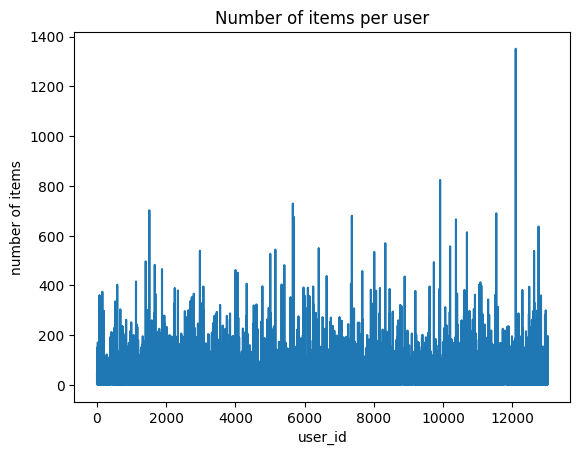

In [17]:
train_data.groupby('row').count().col.plot()
plt.xlabel('user_id')
plt.ylabel('number of items')
plt.title('Number of items per user');

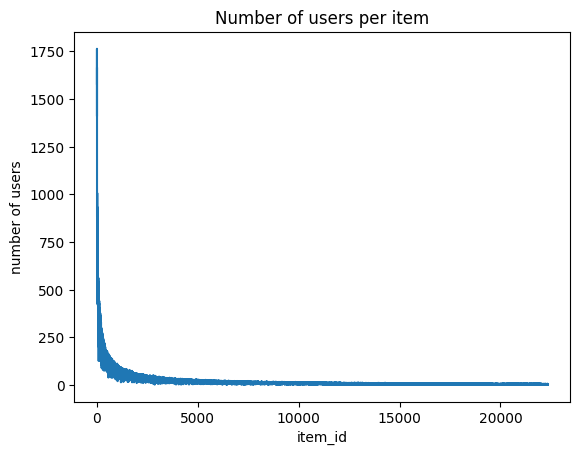

In [18]:
train_data.groupby('col').count().row.plot()
plt.xlabel('item_id')
plt.ylabel('number of users')
plt.title('Number of users per item');

In [19]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Cross Validation Split

In [20]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [21]:
from Data_manager.IncrementalSparseMatrix import IncrementalSparseMatrix


class CrossValidationSplitter:
    def __init__(self, n_splits):
        self.n_splits = n_splits
        self.folds = []
        
    def split(self, URM):
        n_int_per_split = int(URM.nnz / self.n_splits)
        indices = np.arange(0, URM.nnz, 1)
        np.random.shuffle(indices)
        num_users, num_items = URM.shape
        
        URM_all = sps.coo_matrix(URM)
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                indices_valid = indices[n_int_per_split * i:]
                indices_train = indices[:n_int_per_split * i]
            else:
                indices_valid = indices[n_int_per_split * i: n_int_per_split * (i + 1)]
                indices_train_1 = indices[n_int_per_split * max(0, i - 1): n_int_per_split * i]
                indices_train_2 = indices[n_int_per_split * (i + 1):]
                indices_train = np.concatenate((indices_train_1, indices_train_2))
                
            URM_valid_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_train_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_valid_builder.add_data_lists(
                URM_all.row[indices_valid],
                URM_all.col[indices_valid],
                URM_all.data[indices_valid]
            )
            
            URM_train_builder.add_data_lists(
                URM_all.row[indices_train],
                URM_all.col[indices_train],
                URM_all.data[indices_train]
            )
            
            yield URM_train_builder.get_SparseMatrix(), URM_valid_builder.get_SparseMatrix()

# Experiments

In [22]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [23]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

# Hyperparameters tuning

In [24]:
import sqlite3

def print_all_rows(table_name, database_path):
    connection = sqlite3.connect(database_path)
    cursor = connection.cursor()

    try:
        cursor.execute(f"SELECT * FROM {table_name};")
        rows = cursor.fetchall()

        print(f"All rows from table '{table_name}':")
        for row in rows:
            print(row)

    except sqlite3.Error as e:
        print(f"Error reading data from table '{table_name}': {e}")

    finally:
        cursor.close()
        connection.close()

print_all_rows('studies', config['database_path'])

All rows from table 'studies':
(1, 'hyperparameters_EASE_R')
(2, 'hyperparameters_tuning_knn_user_fixed')
(3, 'hyperparameters_tuning_ials_no_cv')


## Item KNN Collaborative Filtering

Not considering adjusted cosine and pearson since they remove the mean of the interactions, but here there are all interactions equal to 1

In [25]:
from concurrent.futures import ThreadPoolExecutor

def evaluate_item_knn(URM_train, URM_valid, params):
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(**params)

    evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    print(f'MAP is {result_df.loc[10, "MAP"]}')
    return result_df.loc[10, 'MAP']


def objective_item_knn(trial):
    params = {
        'topK': trial.suggest_int('topK', 10, 1000),
        'shrink': trial.suggest_int('shrink', 0, 500),
        'similarity': trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky", "euclidean"]),        
    }
    
    if params['similarity'] == "asymmetric":
        params["asymmetric_alpha"] = trial.suggest_float("asymmetric_alpha", 0, 2, log=False)
        params["normalize"] = True     

    elif params['similarity'] == "tversky":
        params["tversky_alpha"] = trial.suggest_float("tversky_alpha", 0, 2, log=False)
        params["tversky_beta"] = trial.suggest_float("tversky_beta", 0, 2, log=False)
        params["normalize"] = True 

    elif params['similarity'] == "euclidean":
        params["normalize_avg_row"] = trial.suggest_categorical("normalize_avg_row", [True, False])
        params["similarity_from_distance_mode"] = trial.suggest_categorical("similarity_from_distance_mode", ["lin", "log", "exp"])
        params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    
    results = [None] * 10
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            futures.append(executor.submit(evaluate_item_knn, URM_train, URM_valid, params))
        print(len(futures))
        for j, future in enumerate(futures):
            results[j] = future.result()
        
    return np.mean(results)

In [26]:
%%time

if config['tune_parameters_item_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_item', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_item_knn, n_trials=50)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 11 µs


In [27]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [28]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [29]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [30]:
if config['tune_parameters_item_knn']:
    with open('/kaggle/working/best_params_knn_item.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_item.json', 
            'tuning_results/best_params_knn_item.json', 
            'Item KNN tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning-better/best_params_knn_item.json', 
        '/kaggle/working/best_params_knn_item.json'
    )

## User KNN Collaborative Filtering

In [31]:
def evaluate_user_knn(URM_train, URM_valid, params):
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(**params)

    evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    print(f'MAP is {result_df.loc[10, "MAP"]}')
    return result_df.loc[10, 'MAP']

def objective_user_knn(trial):
    params = {
        'topK': trial.suggest_int('topK', 10, 1000),
        'shrink': trial.suggest_int('shrink', 0, 500),
        'similarity': trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky", "euclidean"]),        
    }
    
    if params['similarity'] == "asymmetric":
        params["asymmetric_alpha"] = trial.suggest_float("asymmetric_alpha", 0, 2, log=False)
        params["normalize"] = True     

    elif params['similarity'] == "tversky":
        params["tversky_alpha"] = trial.suggest_float("tversky_alpha", 0, 2, log=False)
        params["tversky_beta"] = trial.suggest_float("tversky_beta", 0, 2, log=False)
        params["normalize"] = True 

    elif params['similarity'] == "euclidean":
        params["normalize_avg_row"] = trial.suggest_categorical("normalize_avg_row", [True, False])
        params["similarity_from_distance_mode"] = trial.suggest_categorical("similarity_from_distance_mode", ["lin", "log", "exp"])
        params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    
    results = [None] * 10
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            futures.append(executor.submit(evaluate_user_knn, URM_train, URM_valid, params))
        print(len(futures))
        for j, future in enumerate(futures):
            results[j] = future.result()
    return np.mean(results)

In [32]:
%%time

if config['tune_parameters_user_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_user_fixed',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_user_knn, n_trials=125)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


In [33]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [34]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [35]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [36]:
if config['tune_parameters_user_knn']:
    with open('/kaggle/working/best_params_knn_user.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_user.json', 
            'tuning_results/best_params_knn_user.json', 
            'User KNN tuning results (from kaggle notebook)'
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning-better/best_params_knn_user.json', 
        '/kaggle/working/best_params_knn_user.json'
    )

# Alternating Least Squares

In [37]:
def objective_ials(trial):
    params = {
        'reg': trial.suggest_float('reg', 1e-7, 10, log=True),
        'alpha': trial.suggest_float('alpha', 0.01, 10),
        'num_factors': trial.suggest_int('num_factors', 5, 300),
        'confidence_scaling': trial.suggest_categorical('confidence_scaling', ['linear', 'log'])
    }
    
    if params['confidence_scaling'] == 'log':
        params['epsilon'] = trial.suggest_float('epsilon', 0.1, 10, log=True)
        
    evaluator_validation = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
    early_stopping_params = {
        'epochs_min': 1,
        'stop_on_validation': True,
        'validation_every_n': 1,
        'validation_metric': 'MAP',
        'lower_validations_allowed': 15,
        'evaluator_object': evaluator_validation
    }

    recommender = IALSRecommender(URM_train)
    recommender.fit(**params, **early_stopping_params)
    
    epochs = recommender.get_early_stopping_final_epochs_dict()["epochs"]
    trial.set_user_attr("epochs", epochs) 

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    return result_df.loc[10, 'MAP']

In [38]:
%%time

if config['tune_parameters_ials']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_ials_no_cv',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_ials, n_trials=8)

[I 2023-11-28 21:20:07,304] Using an existing study with name 'hyperparameters_tuning_ials_no_cv' instead of creating a new one.


EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 627 ( 4.8%) users with no interactions.
IALSRecommender: URM Detected 247 ( 1.1%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 10456 (100.0%) in 11.90 sec. Users per second: 878
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0247035, PRECISION_RECALL_MIN_DEN: 0.0454639, RECALL: 0.0391333, MAP: 0.0097032, MAP_MIN_DEN: 0.0178496, MRR: 0.0777301, NDCG: 0.0381509, F1: 0.0302876, HIT_RATE: 0.1994070, ARHR_ALL_HITS: 0.0866883, NOVELTY: 0.0044916, AVERAGE_POPULARITY: 0.3335461, DIVERSITY_MEAN_INTER_LIST: 0.9429799, DIVERSITY_HERFINDAHL: 0.9942890, COVERAGE_ITEM: 0.0383049, COVERAGE_ITEM_HIT: 0.0145881, ITEMS_IN_GT: 0.8004206, COVERAGE_USER: 0.8028256, COVERAGE_USER_HIT: 0.1600891, USERS_IN_GT: 0.8028256, DIVERSITY_GINI: 0.0087180, SHANNON_ENTROPY: 8.0244160, RATIO_DIVERSITY_HERFINDAHL: 0.9946486, RATIO_DIVERSITY_GINI: 0.0251549, RATIO

[I 2023-11-28 22:28:42,299] Trial 22 finished with value: 0.03522060698801369 and parameters: {'reg': 0.7395362345839561, 'alpha': 3.94061667393803, 'num_factors': 138, 'confidence_scaling': 'linear'}. Best is trial 20 with value: 0.03624355196682131.


EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 627 ( 4.8%) users with no interactions.
IALSRecommender: URM Detected 247 ( 1.1%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 10456 (100.0%) in 12.09 sec. Users per second: 865
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0310157, PRECISION_RECALL_MIN_DEN: 0.0564844, RECALL: 0.0485414, MAP: 0.0126778, MAP_MIN_DEN: 0.0227118, MRR: 0.0962270, NDCG: 0.0478137, F1: 0.0378482, HIT_RATE: 0.2386190, ARHR_ALL_HITS: 0.1101278, NOVELTY: 0.0043687, AVERAGE_POPULARITY: 0.3960822, DIVERSITY_MEAN_INTER_LIST: 0.9098585, DIVERSITY_HERFINDAHL: 0.9909771, COVERAGE_ITEM: 0.0320401, COVERAGE_ITEM_HIT: 0.0121269, ITEMS_IN_GT: 0.8004206, COVERAGE_USER: 0.8028256, COVERAGE_USER_HIT: 0.1915694, USERS_IN_GT: 0.8028256, DIVERSITY_GINI: 0.0058544, SHANNON_ENTROPY: 7.4301274, RATIO_DIVERSITY_HERFINDAHL: 0.9913356, RATIO_DIVERSITY_GINI: 0.0168923, RATIO

[I 2023-11-28 23:43:54,864] Trial 23 finished with value: 0.036145290620711854 and parameters: {'reg': 9.953149899936014, 'alpha': 2.970073003674614, 'num_factors': 184, 'confidence_scaling': 'linear'}. Best is trial 20 with value: 0.03624355196682131.


EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 627 ( 4.8%) users with no interactions.
IALSRecommender: URM Detected 247 ( 1.1%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 10456 (100.0%) in 11.03 sec. Users per second: 948
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0258607, PRECISION_RECALL_MIN_DEN: 0.0462650, RECALL: 0.0394372, MAP: 0.0105975, MAP_MIN_DEN: 0.0191703, MRR: 0.0839207, NDCG: 0.0402551, F1: 0.0312376, HIT_RATE: 0.2056236, ARHR_ALL_HITS: 0.0941029, NOVELTY: 0.0043335, AVERAGE_POPULARITY: 0.4148160, DIVERSITY_MEAN_INTER_LIST: 0.8962878, DIVERSITY_HERFINDAHL: 0.9896202, COVERAGE_ITEM: 0.0274310, COVERAGE_ITEM_HIT: 0.0090840, ITEMS_IN_GT: 0.8004206, COVERAGE_USER: 0.8028256, COVERAGE_USER_HIT: 0.1650799, USERS_IN_GT: 0.8028256, DIVERSITY_GINI: 0.0050373, SHANNON_ENTROPY: 7.2148136, RATIO_DIVERSITY_HERFINDAHL: 0.9899781, RATIO_DIVERSITY_GINI: 0.0145346, RATIO

[I 2023-11-29 00:00:30,336] Trial 24 finished with value: 0.034196910560960206 and parameters: {'reg': 2.3571935190174162, 'alpha': 2.104536060460342, 'num_factors': 64, 'confidence_scaling': 'linear'}. Best is trial 20 with value: 0.03624355196682131.


EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 627 ( 4.8%) users with no interactions.
IALSRecommender: URM Detected 247 ( 1.1%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 10456 (100.0%) in 12.16 sec. Users per second: 860
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0289690, PRECISION_RECALL_MIN_DEN: 0.0547385, RECALL: 0.0477346, MAP: 0.0119092, MAP_MIN_DEN: 0.0227818, MRR: 0.0920665, NDCG: 0.0463514, F1: 0.0360563, HIT_RATE: 0.2287682, ARHR_ALL_HITS: 0.1045150, NOVELTY: 0.0043644, AVERAGE_POPULARITY: 0.3627532, DIVERSITY_MEAN_INTER_LIST: 0.9310533, DIVERSITY_HERFINDAHL: 0.9930964, COVERAGE_ITEM: 0.0397369, COVERAGE_ITEM_HIT: 0.0150356, ITEMS_IN_GT: 0.8004206, COVERAGE_USER: 0.8028256, COVERAGE_USER_HIT: 0.1836609, USERS_IN_GT: 0.8028256, DIVERSITY_GINI: 0.0075771, SHANNON_ENTROPY: 7.8072408, RATIO_DIVERSITY_HERFINDAHL: 0.9934556, RATIO_DIVERSITY_GINI: 0.0218628, RATIO

[I 2023-11-29 02:41:25,725] Trial 25 finished with value: 0.036322309815280805 and parameters: {'reg': 8.80246771889694, 'alpha': 4.102792897864675, 'num_factors': 198, 'confidence_scaling': 'linear'}. Best is trial 25 with value: 0.036322309815280805.


EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 627 ( 4.8%) users with no interactions.
IALSRecommender: URM Detected 247 ( 1.1%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 10456 (100.0%) in 12.32 sec. Users per second: 849
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0244357, PRECISION_RECALL_MIN_DEN: 0.0442460, RECALL: 0.0378621, MAP: 0.0095827, MAP_MIN_DEN: 0.0180966, MRR: 0.0768170, NDCG: 0.0378347, F1: 0.0297021, HIT_RATE: 0.1963466, ARHR_ALL_HITS: 0.0857225, NOVELTY: 0.0045350, AVERAGE_POPULARITY: 0.3148075, DIVERSITY_MEAN_INTER_LIST: 0.9510151, DIVERSITY_HERFINDAHL: 0.9950924, COVERAGE_ITEM: 0.0438985, COVERAGE_ITEM_HIT: 0.0172283, ITEMS_IN_GT: 0.8004206, COVERAGE_USER: 0.8028256, COVERAGE_USER_HIT: 0.1576321, USERS_IN_GT: 0.8028256, DIVERSITY_GINI: 0.0100862, SHANNON_ENTROPY: 8.2369704, RATIO_DIVERSITY_HERFINDAHL: 0.9954523, RATIO_DIVERSITY_GINI: 0.0291027, RATIO

[I 2023-11-29 03:39:09,048] Trial 26 finished with value: 0.03529977471733446 and parameters: {'reg': 0.17908067219147555, 'alpha': 4.124316945363701, 'num_factors': 192, 'confidence_scaling': 'linear'}. Best is trial 25 with value: 0.036322309815280805.


EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 627 ( 4.8%) users with no interactions.
IALSRecommender: URM Detected 247 ( 1.1%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 10456 (100.0%) in 11.83 sec. Users per second: 884
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0250861, PRECISION_RECALL_MIN_DEN: 0.0440411, RECALL: 0.0376987, MAP: 0.0101613, MAP_MIN_DEN: 0.0180201, MRR: 0.0792335, NDCG: 0.0382204, F1: 0.0301255, HIT_RATE: 0.1988332, ARHR_ALL_HITS: 0.0895558, NOVELTY: 0.0044343, AVERAGE_POPULARITY: 0.3367515, DIVERSITY_MEAN_INTER_LIST: 0.9429393, DIVERSITY_HERFINDAHL: 0.9942849, COVERAGE_ITEM: 0.0409898, COVERAGE_ITEM_HIT: 0.0148118, ITEMS_IN_GT: 0.8004206, COVERAGE_USER: 0.8028256, COVERAGE_USER_HIT: 0.1596284, USERS_IN_GT: 0.8028256, DIVERSITY_GINI: 0.0087931, SHANNON_ENTROPY: 8.0343531, RATIO_DIVERSITY_HERFINDAHL: 0.9946445, RATIO_DIVERSITY_GINI: 0.0253717, RATIO

[I 2023-11-29 04:17:26,695] Trial 27 finished with value: 0.03514468414884486 and parameters: {'reg': 2.318127363962177, 'alpha': 4.899426741191244, 'num_factors': 143, 'confidence_scaling': 'linear'}. Best is trial 25 with value: 0.036322309815280805.


EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 627 ( 4.8%) users with no interactions.
IALSRecommender: URM Detected 247 ( 1.1%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 10456 (100.0%) in 10.95 sec. Users per second: 955
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0021232, PRECISION_RECALL_MIN_DEN: 0.0058488, RECALL: 0.0056171, MAP: 0.0011400, MAP_MIN_DEN: 0.0029853, MRR: 0.0103247, NDCG: 0.0051458, F1: 0.0030816, HIT_RATE: 0.0192234, ARHR_ALL_HITS: 0.0108625, NOVELTY: 0.0003143, AVERAGE_POPULARITY: 0.0628996, DIVERSITY_MEAN_INTER_LIST: 0.9221969, DIVERSITY_HERFINDAHL: 0.9922109, COVERAGE_ITEM: 0.0146328, COVERAGE_ITEM_HIT: 0.0005817, ITEMS_IN_GT: 0.8004206, COVERAGE_USER: 0.8028256, COVERAGE_USER_HIT: 0.0154330, USERS_IN_GT: 0.8028256, DIVERSITY_GINI: 0.0057463, SHANNON_ENTROPY: 7.3946035, RATIO_DIVERSITY_HERFINDAHL: 0.9925697, RATIO_DIVERSITY_GINI: 0.0165805, RATIO

[I 2023-11-29 04:32:16,343] Trial 28 finished with value: 0.020645828020062935 and parameters: {'reg': 0.2658946497680714, 'alpha': 3.5433091612057357, 'num_factors': 10, 'confidence_scaling': 'linear'}. Best is trial 25 with value: 0.036322309815280805.


EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 627 ( 4.8%) users with no interactions.
IALSRecommender: URM Detected 247 ( 1.1%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 10456 (100.0%) in 20.55 sec. Users per second: 509
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0285004, PRECISION_RECALL_MIN_DEN: 0.0533075, RECALL: 0.0463062, MAP: 0.0118295, MAP_MIN_DEN: 0.0222591, MRR: 0.0934782, NDCG: 0.0457246, F1: 0.0352842, HIT_RATE: 0.2253252, ARHR_ALL_HITS: 0.1048941, NOVELTY: 0.0044326, AVERAGE_POPULARITY: 0.3364879, DIVERSITY_MEAN_INTER_LIST: 0.9423078, DIVERSITY_HERFINDAHL: 0.9942218, COVERAGE_ITEM: 0.0427350, COVERAGE_ITEM_HIT: 0.0175415, ITEMS_IN_GT: 0.8004206, COVERAGE_USER: 0.8028256, COVERAGE_USER_HIT: 0.1808968, USERS_IN_GT: 0.8028256, DIVERSITY_GINI: 0.0088210, SHANNON_ENTROPY: 8.0355224, RATIO_DIVERSITY_HERFINDAHL: 0.9945814, RATIO_DIVERSITY_GINI: 0.0254520, RATIO

[I 2023-11-29 05:55:12,666] Trial 29 finished with value: 0.03499245136080483 and parameters: {'reg': 1.3007149748581002, 'alpha': 1.8279985776996504, 'num_factors': 271, 'confidence_scaling': 'linear'}. Best is trial 25 with value: 0.036322309815280805.


CPU times: user 21h 33min 35s, sys: 8h 21min 1s, total: 1d 5h 54min 36s
Wall time: 8h 35min 5s


In [39]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [40]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [41]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [42]:
if config['tune_parameters_ials']:
    with open('/kaggle/working/best_params_ials_v2.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_ials_v2.json', 
            'tuning_results/best_params_ials_v2.json', 
            'IALS tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_ials_v2.json', 
        '/kaggle/working/best_params_ials_v2.json'
    )

In [43]:
if config['save_github'] and (config['tune_parameters_user_knn'] or config['tune_parameters_item_knn'] or config['tune_parameters_ials']):
    upload_file(
        config['database_path'], 
        'tuning_results/better_tuning.db', 
        'Tuning db updated results (from kaggle notebook)'
    )

# Training best model

In [44]:
# with open('/kaggle/working/best_params_knn_item.json', 'r') as params_file:
#     params_knn = json.load(params_file)

# recommender = ItemKNNCFRecommender(URM_all)
# recommender.fit(topK=params_knn['topK'], shrink=params_knn['shrink'], similarity=params_knn['similarity'])

# Submission

In [45]:
# user_ids_test.info()

In [46]:
# user_ids_test.head(5)

In [47]:
# user_ids_test['user_id'].unique()

In [48]:
# # user_id and item_id start from 1
# recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10)
# recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

# submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
# submission_df.head()

In [49]:
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)